# ACOM of AuAgPd nanowires - disk detection

This notebook performs disk detection for the AuAgPd nanowire 4D-STEM bullseye experiment. The data has been downsampled for the purposes of the tutorial.

Our goal is to perform automated crystal orientation mapping (ACOM), as described in: <br>
[Automated Crystal Orientation Mapping in py4DSTEM using Sparse Correlation Matching](https://doi.org/10.1017/S1431927622000101)

### Data

[polycrystal_2D_WS2.h5](https://drive.google.com/file/d/1AWB3-UTPiTR9dgrEkNFD7EJYsKnbEy0y/view?usp=sharing) (1.0 GB)

[WS2.cif](https://drive.google.com/file/d/13zBl6aFExtsz_sew-L0-_ALYJfcgHKjo/view?usp=sharing) (2 kB)

This dataset is a simulation of a polycrystalline WS2 thin film, where each grain has an [0001] zone axis orientation, and a random in-plane rotation. Each grain has been randomly strained by -2%, -1%, 0%, 1%, or 2%, for e_xx, e_yy, and e_xy. This makes checking the output strain maps easier, as each grain has an exact multiple of 1% strain for each value in the strain tensor. The dataset for this tutorial has also been downsampled in both real and diffraction space to make a small example.

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Alex Rakowski (arakowski@lbl.gov)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.13.6


In [2]:
file_data = '/media/cophus/DataSSD1/data/polycrystal_2D_WS2.h5'
file_path_analysis = '/media/cophus/DataSSD1/data/polycrystal_2D_WS2_analysis_'
file_cif = '/media/cophus/DataSSD1/data/WS2.cif'

# Load data

In [3]:
py4DSTEM.io.print_h5_tree(file_data)

/
|--4DSTEM
	|--datacube
		|--calibration




In [4]:
# Load the datacubes using py4DSTEM
dataset = py4DSTEM.read(
    file_data,
    root='4DSTEM/datacube',
)

# Virtual imaging

In [5]:
dataset.get_dp_max()
dataset.get_dp_mean()

DiffractionImage( A 2-dimensional array of shape (128, 128) called 'dp_mean',
                  with dimensions:

                  dim0 = [0,1,...] pixels
                  dim1 = [0,1,...] pixels
)

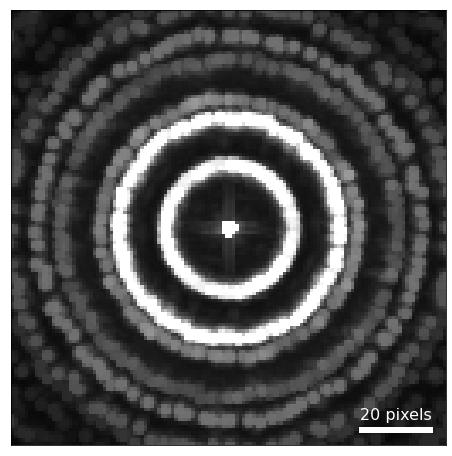

In [6]:
py4DSTEM.visualize.show(
    dataset.tree['dp_max'],
    clipvals='manual',
    vmin=0,
    vmax=3e-5,
    scaling='power',
    power=0.5,
)

We can see the polycrystalline grain structure of the WS2 in the maximum diffraction pattern. Many diffraction rings are present, with Bragg peaks at many different rotations along these rings.

Estimated probe radius = 1.86 pixels


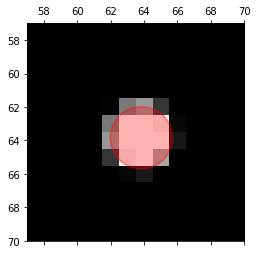

In [7]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(
    dataset.tree['dp_mean'].data,
)
center = (probe_qx0, probe_qy0)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
fig, ax = py4DSTEM.visualize.show_circles(
    dataset.tree['dp_mean'].data,
    center, 
    probe_semiangle,
    figsize=(4,4),
    returnfig=True,
)
ax.set_xlim([57, 70])
ax.set_ylim([70, 57])

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

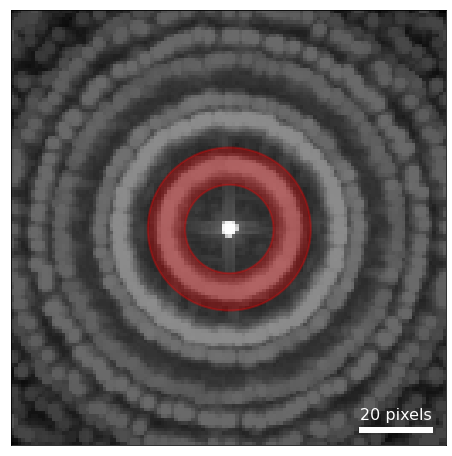

100%|██████████████████████████████████████████████████████████████████████████| 16384/16384 [00:00<00:00, 39640.76it/s]


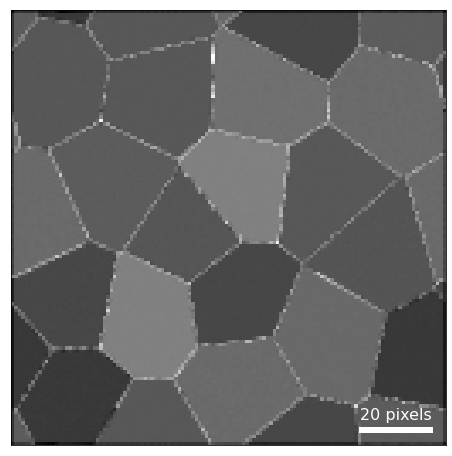

In [8]:
# Create a virtual annular dark field (ADF) image around the first diffraction ring

radii = (13,24)

# Plot the ADF detector
py4DSTEM.visualize.show(
    dataset.tree['dp_max'], 
    scaling='log',
    annulus = {
      'center':center,
      'radii':radii,
      'alpha':0.3,
      'fill':True
    }
)

# Calculate the ADF image
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'dark_field',
)

# Plot the ADF image
py4DSTEM.visualize.show(dataset.tree['dark_field'])

Two kinds of contrast changes are visible in the virtual dark field image:

 - The grain boundaries show up as bright lines bordering the polycrystalline grains.
 - Some grains appear brighter or darker - this is because the applied strain fields increase or decrease the atomic density of the grains, leading to more or less diffraction into the annular dark field region.

# Probe template

In [9]:
# Because the diffracted signal is so weak, we will just average a subset of the probe positions.
rx_min, rx_max = 10, 30
ry_min, ry_max = 10, 30

probe_init = py4DSTEM.process.probe.get_probe_from_4Dscan_ROI_lims(
    dataset,
    ROI=(rx_min, rx_max, ry_min, ry_max),
#     mask,
    align=True,
)

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 330.89it/s]


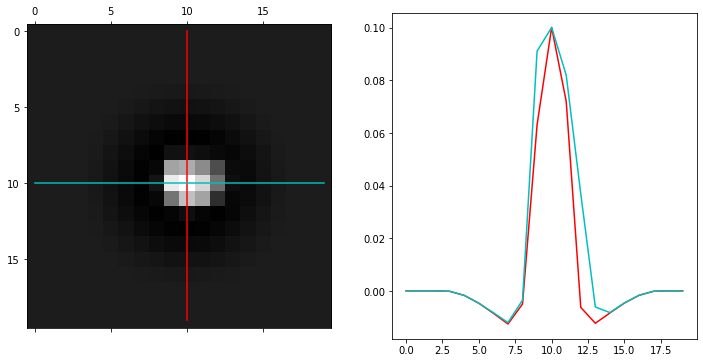

In [10]:
# Subtract a normalization function to give the probe a mean value of zero 
probe_kernel = py4DSTEM.process.probe.get_probe_kernel_edge_sigmoid(
    probe_init, 
    (probe_semiangle * 0.0, probe_semiangle * 4.0),
    bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=10, L=10, W=1)

# Bragg disk detection

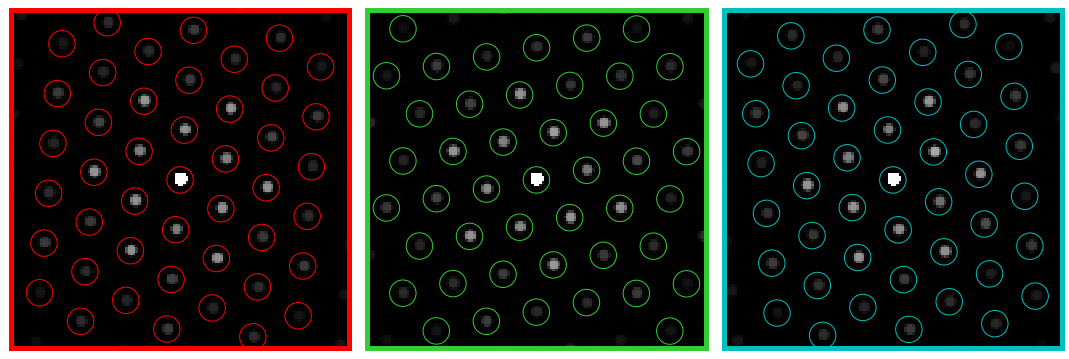

In [11]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

rxs = 32,96,96
rys = 32,32,96
colors=['r','limegreen','c']


# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 4,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 1e-7,
    'minPeakSpacing': 12,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=1, 
    W=3,
    axsize=(5,5),
    clipvals='manual',
    vmin=0,
    vmax=1e-4,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [12]:
# Find Bragg peaks for all probe positions
bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████| 16.4k/16.4k [02:02<00:00, 134DP/s]


# Centering and calibration

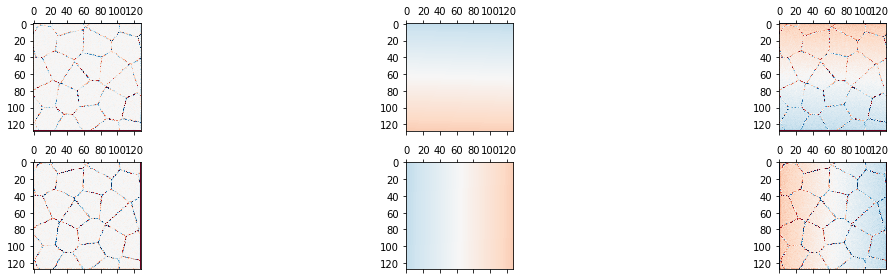

In [13]:
# Compute the origin position for all probe positions.
# This algorithm works by searching for peak pairs (Friedel symmetry) and finding the mean position of these pairs.

qxy_origins = bragg_peaks.measure_origin(
    mode = 'no_beamstop',
)

# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin(
    plot_range=0.002,
)

In [14]:
# apply the calibration
bragg_peaks.calibration.set_origin((qx0_fit, qy0_fit))
bragg_peaks.calibrate()

# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()

# Pixel size calibration

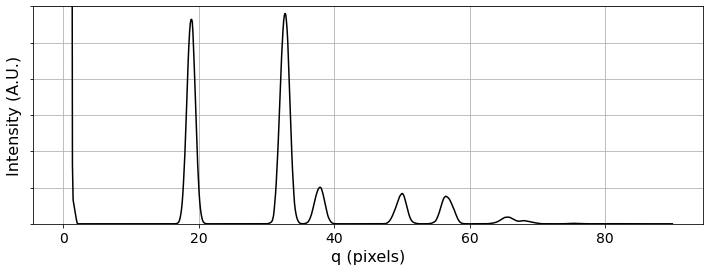

In [15]:
# Calculate and plot the radial integral.
# Note that for a 2D material, the center beam is orders of magnitude higher than the diffracted beam.
# Thus we need to specify a maximum y value for the plot.
# We also scale the plotted intensity by q to better show the higher angle peaks.
ymax = 30

q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    bragg_vector_map_centered,
)

py4DSTEM.visualize.show_qprofile(
    q = q,
    intensity = intensity_radial * q,
    ymax = ymax,
)

In [16]:
# Load the WS2 crystal file
crystal = py4DSTEM.process.diffraction.Crystal.from_CIF(file_cif)

/home/cophus/anaconda3/envs/py4DSTEM_dev/lib/python3.8/site-packages/pymatgen/io/cif.py:1155: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [17]:
# Calculate structure factors
k_max = 1.4

crystal.calculate_structure_factors(
    k_max,
)

(0.0, 1.4)

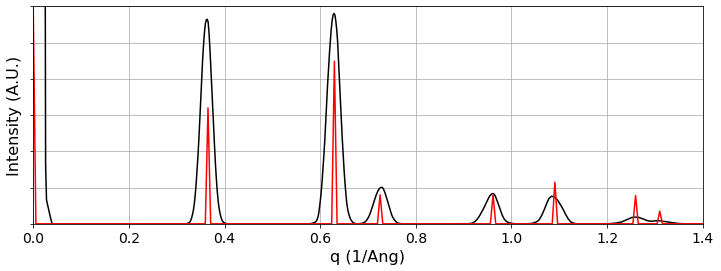

In [18]:
# Test different pixel sizes, and overlay the structure factors onto the experimental data.
# Note that we will use our knowledge that the WS2 has an [0001] zone axis.

inv_Ang_per_pixel = 0.0192

q_SF = np.linspace(0,k_max,250)
I_SF = np.zeros_like(q_SF)
for a0 in range(crystal.g_vec_leng.shape[0]):
    if np.abs(crystal.g_vec_all[2,a0]) < 0.01:
        idx = np.argmin(np.abs(q_SF-crystal.g_vec_leng[a0]))
        I_SF[idx] += crystal.struct_factors_int[a0]
I_SF /= np.max(I_SF)

fig,ax = py4DSTEM.visualize.show_qprofile(
    q=q*inv_Ang_per_pixel,
    intensity=intensity_radial*q,
    xlabel='q (1/Ang)',
    returnfig=True,
    ymax=ymax,
)

ax.plot(q_SF,I_SF*ymax,c='r')
ax.set_xlim([0, k_max])

In [19]:
# Apply pixel size calibration
bragg_peaks.calibration.set_Q_pixel_size(inv_Ang_per_pixel)
bragg_peaks.calibration.set_Q_pixel_units('A^-1')
bragg_peaks.calibrate()

In [20]:
# Save calibrated Bragg peaks
file_name_braggdisks_cali = file_path_analysis + 'braggdisks_cali.h5'
py4DSTEM.save(
    file_name_braggdisks_cali,
    bragg_peaks,
    mode='o',
)

100%|███████████████████████████████████████████████████████████████████████████| 16384/16384 [00:03<00:00, 5386.88it/s]


# Automated crystal orientation mapping (ACOM)

In [21]:
# Reload Bragg peaks if needed
file_name_braggdisks_cali = file_path_analysis + 'braggdisks_cali.h5'
py4DSTEM.io.print_h5_tree(file_name_braggdisks_cali)

/
|--4DSTEM
	|--braggvectors
		|--_v_cal
		|--_v_uncal
		|--calibration




In [22]:
# Reload bragg peaks cif file, recompute structure factors
bragg_peaks = py4DSTEM.read(
    file_name_braggdisks_cali, 
    root = '/4DSTEM/braggvectors'
)
bragg_peaks

k_max = 1.4
crystal = py4DSTEM.process.diffraction.Crystal.from_CIF(file_cif)
crystal.calculate_structure_factors(
    k_max,
)

Reading PointListArray: 100%|████████████████████████████████████████████| 16384/16384 [00:02<00:00, 5711.59PointList/s]


In [23]:
# Create an orientation plan for [0001] WS2
crystal.orientation_plan(
    angle_step_zone_axis = 1.0,
    angle_step_in_plane = 4.0,
    zone_axis_range = 'fiber',
    fiber_axis = [0,0,1],
    fiber_angles = [0,0],
#     CUDA=True,
)

Orientation plan: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 84.25 zone axes/s]


Best fit zone axis (lattice) = ([-0. -0.  1.]), with corr value = 0.181


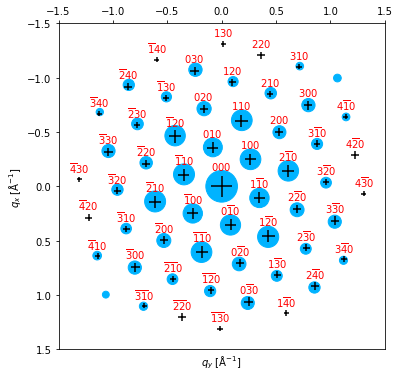

In [24]:
# Test matching on some probe positions
# xind, yind = 64,64
xind, yind = 32,96

orientation  = crystal.match_single_pattern(
    bragg_peaks.vectors[xind,yind],
#     plot_corr = True,
#     plot_polar = False,
    verbose = True,
)

sigma_compare = 0.03
range_plot = np.array([k_max+0.1,k_max+0.1])

bragg_peaks_fit = crystal.generate_diffraction_pattern(
    orientation,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)


# plot comparisons
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks.vectors[xind,yind],
    scale_markers=1000,
    scale_markers_compare=1e5,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
)

In [25]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks.vectors,
)

Matching Orientations: 100%|█████████████████████████████████████████████| 16384/16384 [00:58<00:00, 281.25 PointList/s]


In [26]:
orientation_map.angles[0:2,0:2,0,2]

array([[5.42736134, 8.56877142],
       [5.42706774, 8.56874145]])

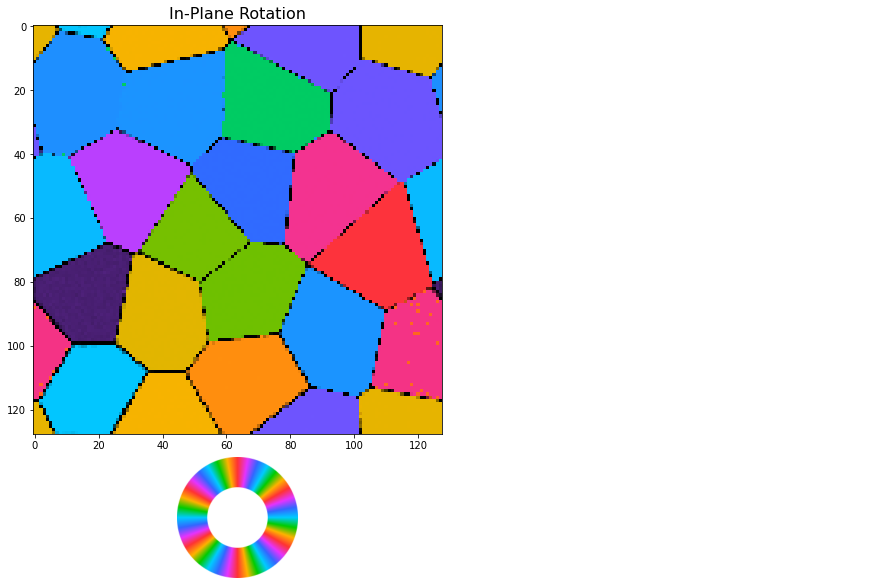

In [27]:
# Plot the orienations 
images_orientation = crystal.plot_fiber_orientation_maps(
    orientation_map,
    symmetry_order = 6,
    corr_range = [0.8,0.9],
)

# Strain maps 

For each diffraction pattern, we have both the measured diffraction pattern Bragg peaks, and the Bragg peaks calculated from the best-fit orientation. We can therefore directly calculate a strain map, just by measuring the best-fit transformation tensor between these two sets of peaks.

In [28]:
strain_map = crystal.calculate_strain(
    bragg_peaks.vectors,
    orientation_map,
    rotation_range=np.pi/3,
#     corr_kernel_size=0.02,
)

Calculating strains: 100%|██████████████████████████████████████████████| 16384/16384 [00:13<00:00, 1227.80 PointList/s]


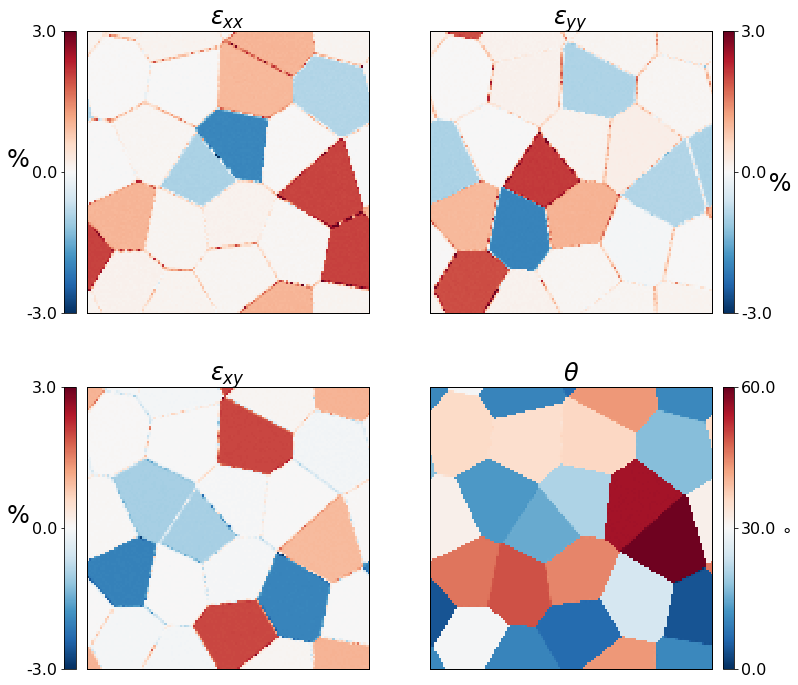

In [29]:
# plot the 4 components of the strain tensor
fig,ax = py4DSTEM.visualize.show_strain(
    strain_map,
    vrange_exx=[-3.0, 3.0],
    vrange_theta=[0.0, 60.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(12,12),
#     cmap='hsv',
    returnfig=True
)